# ACSIncome Experiment

In this notebook, we will draw the constraint violation as well as the accuracy of a deferral system for estimating the income of a person based on their features. We start by importing data analysis and illustration tools.

In [1]:
import sys
sys.path.append("../")
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import joblib

Next, we import random forest classifier from sklearn module. This classifier helps estimating the scores of the corresponding task

In [2]:
from sklearn.ensemble import RandomForestClassifier

We further import the dataset from [Folktables](https://github.com/socialfoundations/folktables).

In [3]:
import folktables

We use similar data preparation as of  [Cruz et al. 2024](https://github.com/socialfoundations/error-parity) to have proper formatting for our random forest learning.

In [4]:

ACS_TASK = "ACSIncome"
SEED = 42
EPS = 1e-6
data_dir = Path("~").expanduser() / "data" / "folktables" / "train=0.6_test=0.2_validation=0.2_max-groups=4"
ACS_CATEGORICAL_COLS = {
    'COW',  # class of worker
    'MAR',  # marital status
    'OCCP',  # occupation code
    'POBP',  # place of birth code
    'RELP',  # relationship status
    'SEX',
    'RAC1P',  # race code
    'DIS',  # disability
    'ESP',  # employment status of parents
    'CIT',  # citizenship status
    'MIG',  # mobility status
    'MIL',  # military service
    'ANC',  # ancestry
    'NATIVITY',
    'DEAR',
    'DEYE',
    'DREM',
    'ESR',
    'ST',
    'FER',
    'GCL',
    'JWTR',
    # 'PUMA',
    # 'POWPUMA',
}


def split_X_Y_S(data, label_col: str, sensitive_col: str,
                ignore_cols=None, unawareness=False) -> tuple:
    ignore_cols = ignore_cols or []
    ignore_cols.append(label_col)
    if unawareness:
        ignore_cols.append(sensitive_col)

    feature_cols = [c for c in data.columns if c not in ignore_cols]

    return (
        data[feature_cols],                           # X
        data[label_col].to_numpy().astype(int),       # Y
        data[sensitive_col].to_numpy().astype(int),   # S
    )


def load_ACS_data(dir_path: str, task_name: str,
                  sensitive_col: str = None) -> pd.DataFrame:
    """Loads the given ACS task data from pre-generated datasets.

    Returns
    -------
    dict[str, tuple]
        A list of tuples, each tuple composed of (features, label,
        sensitive_attribute).
        The list is sorted as follows" [<train data tuple>, <test data tuple>,
        <val. data tuple>].
    """
    # Load task object
    task_obj = getattr(folktables, task_name)

    # Load train, test, and validation data
    data = dict()
    for data_type in ['train', 'test', 'validation']:
        # Construct file path
        path = Path(dir_path) / f"{task_name}.{data_type}.csv"

        if not path.exists():
            print(f"Couldn't find data\
                  for '{path.name}' \
                  (this is probably expected).")
            continue

        # Read data from disk
        df = pd.read_csv(path, index_col=0)

        # Set categorical columns
        cat_cols = ACS_CATEGORICAL_COLS & set(df.columns)
        df = df.astype({col: "category" for col in cat_cols})

        data[data_type] = split_X_Y_S(
            df,
            label_col=task_obj.target,
            sensitive_col=sensitive_col or task_obj.group,
        )

    return data

We further simulate human as following that makes different noises on different demographic groups.

In [5]:

def human_sim(y_train, y_test, y_val, s_train, s_test, s_val, val=True):
    M_test = np.zeros(len(y_test))
    M_val = np.zeros(len(y_val))

    def noisy(y, s):
        m = np.zeros(len(y))
        for i in range(len(y)):
            if s[i] == 0:
                random = np.random.uniform(0, 1)
                if random < 0.85:
                    m[i] = y[i]
                else:
                    m[i] = 1-y[i]
            else:
                random = np.random.uniform(0, 1)
                if random < 0.6:
                    m[i] = y[i]
                else:
                    m[i] = 1-y[i]
        m = m.astype(int)
        return m
    M_test = noisy(y_test, s_test)
    M_train = noisy(y_train, s_train)
    if val:
        M_val = noisy(y_val, s_val)
    else:
        print("No validation data.")
    return M_train, M_test, M_val


Next, I generate the data that I need to train the scores. This includes the features, targets, demographic group, human decision, and human correctness on training, validation, and test data.

In [6]:
def process_data():
    #  Load and pre-process data
    all_data = load_ACS_data(
        dir_path=data_dir, task_name=ACS_TASK,
    )
    # Unpack into features, label, and group
    X_train, y_train, s_train = all_data["train"]
    X_test, y_test, s_test = all_data["test"]
    if "validation" in all_data:
        X_val, y_val, s_val = all_data["validation"]
    else:
        print("No validation data.")

    actual_prevalence = np.sum(y_train) / len(y_train)
    print(f"Global prevalence: {actual_prevalence:.1%}")
    if "validation" in all_data:
        val_data = True
    M_train, M_test, M_val = human_sim(y_train, y_test, y_val, s_train, s_test,
                                       s_val,
                                       val=val_data)

    # find the new labels that are M==Y
    MY_train = np.where(y_train == M_train, 1, 0)
    MY_test = np.where(y_test == M_test, 1, 0)
    if "validation" in all_data:
        MY_val = np.where(y_val == M_val, 1, 0)
        # print("MY_val:", MY_val)
    else:
        print("No validation data.")
    return X_train, y_train, s_train, X_test, y_test, s_test, X_val, y_val, \
        s_val, M_train, M_test, M_val, MY_train, MY_test, MY_val



Next, I define functions to find embedding functions for the loss as well as the constraint.

In [7]:

def process_score_labels(M_train, M_test, M_val, y_train, y_test, y_val,
                         val=True, constraint='eo'):
    # Here I make labels L_train, L_test, L_val
    n_s = 1 + 1
    L_train = 2 * M_train + y_train
    L_test = 2 * M_test + y_test
    # print("L_test:", L_test)
    if val:
        L_val = 2 * M_val + y_val
        return L_train, L_test, L_val, n_s
    else:
        return L_train, L_test, n_s


def witness(rf_out_witness, A,
            ps,
            type_witness="eo"):
    # rf_out = rf_out_witness
    pa0, pa1, pa0y0, pa0y1, pa1y0, pa1y1 = ps
    if type_witness == "dp":
        t = []
        for i in range(len(A)):
            if A[i] == 0:
                t.append(1/pa0)
            elif A[i] != 0:
                t.append(-1/pa1)
        t = np.array(t)
        idxm1 = idx_M[1]
        pm1x = np.sum(rf_out_witness[:, idxm1], axis=1)
        ret = np.zeros([rf_out_witness.shape[0], 3])

        ret[:, 0] = 0.0*rf_out_witness.shape[0]
        ret[:, 1] = t
        ret[:, 2] = t*pm1x

    elif type_witness == "eo":
        t0 = []
        for i in range(len(A)):
            if A[i] == 1:
                t0.append(1/pa1y0)
            else:
                t0.append(-1/pa0y0)
        t1 = []
        for i in range(len(A)):
            if A[i] == 0:
                t1.append(1/pa0y1)
            elif A[i] != 0:
                t1.append(-1/pa1y1)
        idxm1y1 = np.intersect1d(idx_M[1], idx_y[1])
        idxy1 = idx_y[1]
        idxy0 = idx_y[0]
        idxm1y0 = np.intersect1d(idx_M[1], idx_y[0])
        py1x = np.sum(rf_out_witness[:, idxy1], axis=1)
        py0x = np.sum(rf_out_witness[:, idxy0], axis=1)
        pm1y1x = rf_out_witness[:, idxm1y1] 
        pm1y0x = rf_out_witness[:, idxm1y0]
        ret = np.zeros([rf_out_witness.shape[0], 2, 3])
        ret[:, 0, 0] = 0.0*rf_out_witness.shape[0]
        ret[:, 0, 1] = t1*py1x
        ret[:, 0, 2] = t1*pm1y1x[:, 0]
        ret[:, 1, 0] = 0.0*rf_out_witness.shape[0]
        ret[:, 1, 1] = t0*py0x
        ret[:, 1, 2] = t0*pm1y0x[:, 0]
        # In this case, the witness function is as
        # 0, py1a1x/py1a1-py1a0x/py1a0, pm1y1a1x/py1a1-pm1y1a0x/py1a0
    return ret


def witness_loss(rf_out, rf_out_my):
    pmy = rf_out_my[:, 1]
    ret = np.zeros([len(rf_out), 3])
    ret[:, :-1] = rf_out
    ret[:, -1] = pmy
    return ret


Next, we define a function to find the Bootstrap for a given function.

In [8]:

def bootstrap_func(function, *args, n_iter=10):
    results = []
    current_args = args
    for i in range(n_iter):
        choice = np.random.choice(len(current_args[0]), len(current_args[0]))
        # choice = np.arange(len(current_args[0]))
        new_args = [arg[choice] for arg in current_args]
        results.append(function(*new_args))
    # if there are more than one output of results, then do average on all
    avg = []
    std = []
    for i in range(len(results[0])):
        res_dim_i = [result[i] for result in results]
        res_dim_i = np.array(res_dim_i)
        # print("res shape:", res_dim_i.shape)
        avg.append(np.average(res_dim_i, axis=0))
        std.append(np.std(res_dim_i, axis=0))
    return avg, std


Next, I train the scores so that I can use it in the estimated embedding function.

In [9]:
def train_scores(X_train, y_train, MY_train, L_train, constraint='eo'):
    # witness
    if Path("rfs.npz").exists():
        rfs = joblib.load("rfs.npz")
        # rfs = [rfs[0], rfs[1], rfs[2]]
        return rfs
    else:
        # save random forests
        rf_clf_witness = RandomForestClassifier(n_jobs=-2)
        rf_clf_witness.fit(X_train, L_train)

        # classifier
        rf_clf = RandomForestClassifier(n_jobs=-2)
        rf_clf.fit(X_train, y_train)
        # rejector
        rf_my = RandomForestClassifier(n_jobs=-2)
        rf_my.fit(X_train, MY_train)
        rfs = [rf_clf, rf_my, rf_clf_witness]
        joblib.dump(rfs, "rfs.npz")

        return rf_clf, rf_my, rf_clf_witness

Next, I define functions to obtain estimated embedding function and the true embedding function based on the data.

In [10]:

def estimate_witnesses(witness, witness_loss, X, A, ps, rfs):
    rf_clf, rf_my, rf_clf_witness = rfs
    rf_out = rf_clf.predict_proba(X)
    rf_out_witness = rf_clf_witness.predict_proba(X)
    rf_out_my = rf_my.predict_proba(X)
    loss = witness_loss(rf_out, rf_out_my)
    w = witness(rf_out_witness, A, ps)
    return loss, w


def true_witness(witness, witness_loss, L, A, ps, MY, y, n_s):

    rf_real = np.zeros([len(y), 2])
    rf_real[np.arange(len(y)), y] = 1
    # turn rf_real_witness into a one-hot vector
    rf_real_witness = np.zeros([len(L), 4])
    rf_real_witness[np.arange(len(L)), L] = 1
    rf_real_my = np.zeros([len(MY), 2])
    rf_real_my[np.arange(len(MY)), MY] = 1
    loss_real = witness_loss(rf_real, rf_real_my)
    w_real = witness(rf_real_witness, A, ps)
    return loss_real, w_real

Next, I go over all the thresholds and find the corresponding embedding function and find the optimal linear combination of the estimated embedding functions to keep the constraint violations controlled.

In [11]:
def find_thresholds(wits, true_wits, X_val, y_val,
                    MY_val, L_val, X_test, y_test, MY_test,
                    s_val, s_test,
                    L_test, threshold_space, tolerance_space,):

    loss, w = wits(X_val, s_val)
    loss_test, w_test = wits(X_test, s_test)
    # turn y_val into a one-hot vector
    loss_real, w_real = true_wits(L_test, s_test, MY_test, y_test)
    loss_real_val, w_real_val = true_wits(L_val, s_val, MY_val, y_val)

    losses_val = []
    ws_val = []
    tt = 0
    for k in threshold_space:
        tt += 1
        print("Threshold:", tt)
        # go over val_data that is a pandas dataframe
        # if k is int, then I need to tile it
        if isinstance(k, float):
            lagrang = loss-k*w
            # print("lagrang:", lagrang)
        else:
            w_sum = k[0]*w[:, 0]
            for i in range(len(k)):
                w_sum += k[i]*w[:, i]
            lagrang = loss-w_sum

        argmax_val = np.argmax(lagrang, axis=1)
        # Here, empirically I find the loss and witness on true labels
        max_loss_val = loss_real_val[np.arange(len(loss_real_val)), argmax_val]
        if len(w_real_val.shape) == 2:
            max_w_val = w_real_val[np.arange(len(w_real_val)), argmax_val]
        elif len(w_real_val.shape) == 3:
            max_w_val = w_real_val[np.arange(len(w_real_val)), :, argmax_val]
        max_loss_val = np.average(max_loss_val, axis=0)
        max_w_val = np.average(max_w_val, axis=0)
        losses_val.append(max_loss_val)
        ws_val.append(max_w_val)
    # now order in terms of w and find corresponding loss and thresholds
    losses_val = np.array(losses_val)
    ws_val = np.array(ws_val)
    loss_out = np.zeros([len(tolerance_space)])
    if len(ws_val.shape) == 1:
        threshold_out = np.zeros([len(tolerance_space)])
        ws_out = np.zeros([len(tolerance_space)])
        ws_std_out = np.zeros([len(tolerance_space)])
    else:
        threshold_out = np.zeros([len(tolerance_space),
                                  len(threshold_space[0])])
        ws_out = np.zeros([len(tolerance_space), len(ws_val[0])])
        ws_std_out = np.zeros([len(tolerance_space), len(ws_val[0])])
    loss_std_out = np.zeros([len(tolerance_space)])
    j = 0
    for tol in tolerance_space:
        print("tolerance:", tol)
        # find the minimum loss for all the ones with ws < tol
        if len(ws_val.shape) == 1:
            indices = np.where(np.abs(ws_val) < np.abs(tol))
        else:
            idxs = []
            for i in range(ws_val.shape[1]):
                idxs.append(np.where(np.abs(ws_val[:, i]) < np.abs(tol)))
            print(idxs)      
            indices = np.intersect1d(*idxs)
        if isinstance(indices, tuple):
            indices = indices[0]
            if len(indices) == 0:
                j += 1
                continue
        else:
            if indices.shape[0] == 0:
                j += 1
                continue
        max_index = np.argmax(losses_val[indices])
        print("max_index:", max_index)
        print("indices:", indices)
        max_index = indices[max_index]
        # find corresponding k
        k_val = threshold_space[max_index]
        # Now find the  argmax_test

        def loss_and_w(loss_est, w_est, lreal, wreal):
            if isinstance(k_val, float):
                lagrang_test = loss_est-k_val*w_est
            else:
                w_sum = k_val[0]*w_est[:, 0]
                for i in range(len(k_val)):
                    w_sum += k_val[i]*w_est[:, i]
                lagrang_test = loss_est-w_sum
            argmax_test = np.argmax(lagrang_test, axis=1)
            max_loss_test = lreal[np.arange(len(lreal)), argmax_test]
            if len(wreal.shape) == 2:
                max_w_test = wreal[np.arange(len(wreal)), argmax_test]
            else:
                max_w_test = wreal[np.arange(len(wreal)), :, argmax_test]
            max_loss_test = np.average(max_loss_test, axis=0)
            max_w_test = np.average(max_w_test, axis=0)
            return max_loss_test, max_w_test
        (loss_out[j], ws_out[j]), (loss_std_out[j], ws_std_out[j]) = \
            bootstrap_func(loss_and_w, loss_test, w_test, loss_real, w_real)
        threshold_out[j] = k_val
        j += 1
    return threshold_out, loss_out, ws_out, loss_std_out, ws_std_out


Then I define the indices in the score vector that corresponds to the positive target and human decision.

In [12]:
idx_y = [[0, 2], [1, 3]]
idx_M = [[0, 1], [2, 3]]


Finally, we define the final function to train the scores, obtain the estimated embedding function and test it.

In [13]:
def train(tolerance_space):
    X_train, y_train, s_train, X_test, y_test, s_test, X_val, y_val, \
        s_val, M_train, M_test, M_val, MY_train, MY_test, MY_val = \
        process_data()
    # Dataset = BrowardDataset("../data", test_split=0.2, val_split=0.1)
    pa0 = np.sum(s_train == 0)/(s_train.shape[0])
    pa1 = np.sum(s_train != 0)/(s_train.shape[0])
    pa1y1 = np.sum((s_train != 0)*(y_train == 1))/(s_train.shape[0])
    pa1y0 = np.sum((s_train != 0)*(y_train == 0))/(s_train.shape[0])
    pa0y1 = np.sum((s_train == 0)*(y_train == 1))/(s_train.shape[0])
    pa0y0 = np.sum((s_train == 0)*(y_train == 0))/(s_train.shape[0])
    ps = (pa0, pa1, pa0y0, pa0y1, pa1y0, pa1y1)
    threshold_space = np.linspace(-.5, .5, 100)  # Eodds + ACS
    threshold_space = np.meshgrid(threshold_space, threshold_space)
    # make a list of threshold_space
    threshold_space = list(zip(threshold_space[0].flatten(), threshold_space[1].flatten()))

    max_losses = []
    max_ws = []
    L_train, L_test, L_val, n_s = process_score_labels(M_train, M_test, M_val,
                                                       y_train, y_test, y_val,)
    if Path("rfs.npz").exists():
        rfs = joblib.load("rfs.npz")
        rfs = [rfs[0], rfs[1], rfs[2]]
    else:
        rfs = train_scores(X_train, y_train, MY_train, L_train)
        joblib.dump(rfs, "rfs.npz")

    def wits(X, A):
        return estimate_witnesses(witness, witness_loss, X, A, ps, rfs)

    def true_wits(L, A, MY, y):
        return true_witness(witness, witness_loss, L, A, ps, MY, y, n_s)

    threshold, max_loss, max_w, max_loss_std, \
        max_w_std = find_thresholds(wits, true_wits, X_val,
                                    y_val, MY_val, L_val, X_test,
                                    y_test, MY_test,
                                    s_val, s_test,
                                    L_test,
                                    threshold_space,
                                    tolerance_space,)
    return tolerance_space, max_loss, max_w, max_loss_std, max_w_std


def postprocess():
    tolerance_space = np.linspace(0.01, 0.2, 1000)
    threshold = []
    max_loss = []
    max_w = []
    max_loss_std = []
    max_w_std = []
    max_iter = 1
    for i in range(max_iter):
        th, ml, mw, mls, mws = train(tolerance_space)
        if i == 0:
            threshold = th
            max_loss = ml
            max_w = mw
            max_loss_std = mls**2
            max_w_std = mws**2
        else:
            threshold += th
            max_loss += ml
            max_w += mw
            max_loss_std += mls**2
            max_w_std += mws**2

    threshold /= max_iter
    max_loss /= max_iter
    max_w /= max_iter
    max_loss_std /= max_iter
    max_w_std /= max_iter
    max_loss_std = np.sqrt(max_loss_std)
    max_w_std = np.sqrt(max_w_std)


    # remove the 0 accuracies, because it means the tolerance is not achievable
    idx_Z = np.where(np.abs(max_loss) > 1e-8)
    idx_Z = idx_Z[0]
    tols = tolerance_space[idx_Z]
    max_loss = max_loss[idx_Z]
    max_loss_std = max_loss_std[idx_Z]
# I plot the accuracy and the witness for the validation data
    plot = False
    if plot:
        plt.fill_between(tols,
                        max_loss-max_loss_std,
                        max_loss+max_loss_std, alpha=0.5)
        max_w_o = []
        max_w_std_o = []
        if isinstance(max_w[0], float):
            max_w_o = np.array(max_w)
            max_w_std_o = np.array(max_w_std)
            plt.fill_between(tols,
                            np.abs(max_w[idx_Z]-max_w_std[idx_Z]),
                            np.abs(max_w[idx_Z]+max_w_std[idx_Z]), alpha=0.5)
        else:
            for i in range(len(max_w[0])):
                max_w_i = np.array([max_w[j][i] for j in range(len(max_w))])
                max_w_std_i = np.array([max_w_std[j][i]
                                        for j in range(len(max_w_std))])
                # now I make a shadowed plot
                max_w_o.append(max_w_i)
                max_w_std_o.append(max_w_std_i)
                plt.fill_between(tols,
                                np.abs(max_w_i[idx_Z]-max_w_std_i[idx_Z]),
                                np.abs(max_w_i[idx_Z]+max_w_std_i[idx_Z]),
                                alpha=0.5)
    return tols, max_loss, max_w[idx_Z], max_loss_std, max_w_std[idx_Z]


def plot_tabular():
    tolerance_space = np.linspace(0.01, 0.2, 100)
    tolerance_space, max_loss, max_w, max_loss_std, max_w_std = train(tolerance_space)
    # remove the max_losses that are zero, because they are not achievable
    idx_Z = np.where(np.abs(max_loss) > 1e-8)
    idx_Z = idx_Z[0]
    tols = tolerance_space[idx_Z]
    max_loss = max_loss[idx_Z]
    max_loss_std = max_loss_std[idx_Z]
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # fill
    plt.fill_between(tols, max_loss-max_loss_std, max_loss+max_loss_std,
                     alpha=0.5)
    plt.plot(tols, max_loss)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.grid()
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=15)
    plt.xlabel("Constraint Tolerance", fontsize=20)
    plt.ylabel("Test Accuracy", fontsize=20)
    fig_size = plt.rcParams["figure.figsize"]

    fig_size[0] = 6
    fig_size[1] = 4.2
    plt.savefig('obj.pdf', bbox_inches='tight', dpi=1000)
    plt.show()
    const_names = ["TPR", "TNR"]
    colors = ['blue', 'red']
    if isinstance(max_w[0], float):
        plt.fill_between(tols, max_w-max_w_std, max_w+max_w_std, alpha=0.5)
        plt.xlabel("Constraint Tolerance")
        plt.ylabel("Constraint Violation")
        plt.show()
    else:
        for i in range(len(max_w[0])):
            max_w_i = np.array([np.abs(max_w[j][i])
                                for j in range(len(max_w))])
            max_w_std_i = np.array([max_w_std[j][i]
                                    for j in range(len(max_w_std))])
            plt.fill_between(tols, max_w_i[idx_Z]-max_w_std_i[idx_Z],
                             max_w_i[idx_Z]+max_w_std_i[idx_Z],
                             alpha=0.5, color=colors[i])
            plt.plot(tols, max_w_i[idx_Z], label=const_names[i],
                     color=colors[i])
            plt.xlabel("Constraint Tolerance", fontsize=20)
            plt.ylabel("Constraint Violation", fontsize=20)
            plt.legend()
    # draw x=y line using dotted
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.grid()
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=15)
    plt.plot(tolerance_space, tolerance_space, 'k--')
    plt.savefig('consts.pdf', bbox_inches='tight', dpi=1000)
    plt.show()


Global prevalence: 37.2%
Threshold: 1
Threshold: 2
Threshold: 3
Threshold: 4
Threshold: 5
Threshold: 6
Threshold: 7
Threshold: 8
Threshold: 9
Threshold: 10
Threshold: 11
Threshold: 12
Threshold: 13
Threshold: 14
Threshold: 15
Threshold: 16
Threshold: 17
Threshold: 18
Threshold: 19
Threshold: 20
Threshold: 21
Threshold: 22
Threshold: 23
Threshold: 24
Threshold: 25
Threshold: 26
Threshold: 27
Threshold: 28
Threshold: 29
Threshold: 30
Threshold: 31
Threshold: 32
Threshold: 33
Threshold: 34
Threshold: 35
Threshold: 36
Threshold: 37
Threshold: 38
Threshold: 39
Threshold: 40
Threshold: 41
Threshold: 42
Threshold: 43
Threshold: 44
Threshold: 45
Threshold: 46
Threshold: 47
Threshold: 48
Threshold: 49
Threshold: 50
Threshold: 51
Threshold: 52
Threshold: 53
Threshold: 54
Threshold: 55
Threshold: 56
Threshold: 57
Threshold: 58
Threshold: 59
Threshold: 60
Threshold: 61
Threshold: 62
Threshold: 63
Threshold: 64
Threshold: 65
Threshold: 66
Threshold: 67
Threshold: 68
Threshold: 69
Threshold: 70
Thre

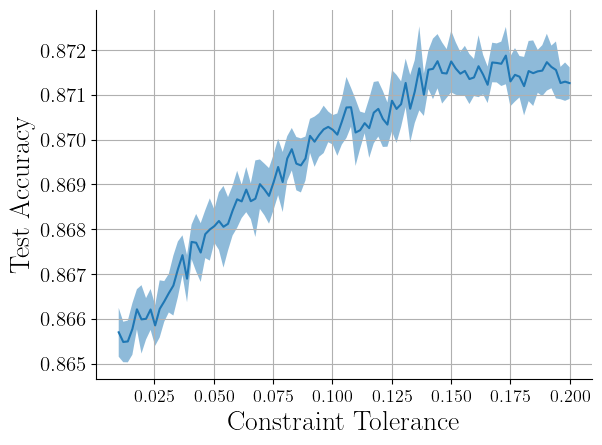

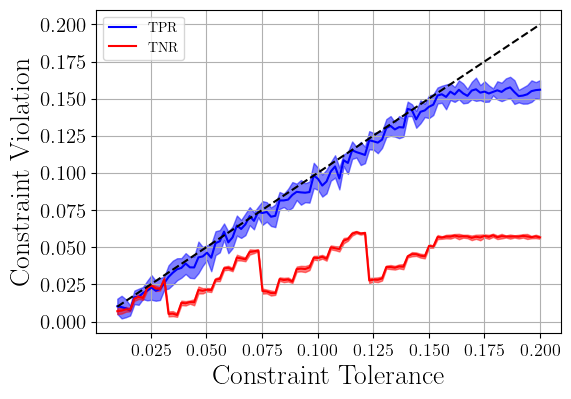

In [14]:
plot_tabular()